In [1]:
import sys
sys.path.append('utils')
import os


In [2]:
import scanpy as sc

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata
import geopandas as gpd

from stardist.models import StarDist2D

from tifffile import imread, imwrite
from csbdeep.utils import normalize
from shapely.geometry import Polygon, Point
from scipy import sparse
from matplotlib.colors import ListedColormap

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

2024-08-28 11:45:45.248610: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
gdf = gpd.read_file('../data/xenium/voronoi.geojson')

In [17]:
gdf['id'] = [f"ID_{i+1}" for i, _ in enumerate(gdf.index)]

In [18]:
gdf

geometry         id
0       POLYGON ((2211.48343 192.66895, 2226.34999 197...       ID_1
1       POLYGON ((3134.63102 2905.93810, 3113.74772 29...       ID_2
2       POLYGON ((3009.97357 3227.42716, 2825.38546 32...       ID_3
3       POLYGON ((3069.17099 3396.28549, 2868.94138 36...       ID_4
4       POLYGON ((3013.24541 3251.47770, 2980.02312 33...       ID_5
...                                                   ...        ...
216318  POLYGON ((27881.08890 21559.50413, 27909.21888...  ID_216319
216319  POLYGON ((28922.30814 21240.85601, 28921.14949...  ID_216320
216320  POLYGON ((27628.11104 21075.78659, 27651.26126...  ID_216321
216321  POLYGON ((28855.34996 20799.55360, 28844.74516...  ID_216322
216322  POLYGON ((28666.64358 22010.55609, 28757.95509...  ID_216323

[216323 rows x 2 columns]

In [2]:
#adata = sc.read_h5ad('../data/xenium/outs/transcripts_anndata_final.h5ad')
import scanpy as sc
adata = sc.read_h5ad('../data/xenium/outs/transcripts_anndata_final_comparison.h5ad')
adata

AnnData object with n_obs × n_vars = 3204769 × 541
    obs: 'start_x', 'start_y', 'end_x', 'end_y', 'center_x', 'center_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'bin_size_pixels', 'log1p', 'pca', 'spatial'
    obsm: 'X_pca', 'end_x', 'end_y', 'spatial', 'start_x', 'start_y'
    varm: 'PCs'

In [5]:
adata_df = adata.to_df()

In [6]:
adata_df.index

Index(['(0, 1376)', '(0, 1400)', '(0, 1402)', '(0, 1415)', '(0, 1425)',
       '(0, 1429)', '(0, 1431)', '(0, 1434)', '(0, 1437)', '(0, 1438)',
       ...
       '(2201, 133)', '(2201, 135)', '(2201, 137)', '(2201, 138)',
       '(2201, 140)', '(2201, 146)', '(2201, 147)', '(2201, 148)',
       '(2201, 153)', '(2201, 154)'],
      dtype='object', name='bin', length=3204769)

In [8]:
df_tissue_positions = adata_df
# Create an index in the dataframe to check joins
df_tissue_positions['index']=df_tissue_positions.index

In [9]:
df_tissue_positions.shape

(3204769, 542)

In [12]:
# Create a GeoDataFrame from the DataFrame of coordinates
geometry = [Point(xy) for xy in zip(adata.obs['center_x'], adata.obs['center_y'])]
gdf_coordinates = gpd.GeoDataFrame(df_tissue_positions, geometry=geometry)

In [17]:
gdf.crs = None

In [34]:
result_spatial_join = gpd.sjoin(gdf_coordinates, gdf, how='left', predicate='within')

NameError: name 'gdf_coordinates' is not defined

In [19]:
result_spatial_join.shape

(3204769, 545)

In [20]:
result_spatial_join[result_spatial_join['index_right'].isna()]

ABCC11     ACTA2     ACTG2     ADAM9    ADGRE5     ADH1B   
bin                                                                      
(2, 915)   -0.239614 -0.331246 -0.327853 -0.266876 -0.131483 -0.172948  \
(2, 916)   -0.239614 -0.331246 -0.327853 -0.266876 -0.131483 -0.172948   
(3, 685)   -0.239614 -0.331246 -0.327853 -0.266876 -0.131483 -0.172948   
(3, 915)   -0.239614 -0.331246 -0.327853 -0.266876 -0.131483 -0.172948   
(3, 916)   -0.239614 -0.331246 -0.327853  3.561163 -0.131483 -0.172948   
...              ...       ...       ...       ...       ...       ...   
(1355, 15) -0.239614 -0.331246  3.286144 -0.266876 -0.131483 -0.172948   
(1355, 17) -0.239614 -0.331246 -0.327853 -0.266876 -0.131483 -0.172948   
(1355, 18) -0.239614 -0.331246 -0.327853 -0.266876 -0.131483 -0.172948   
(1355, 19) -0.239614 -0.331246 -0.327853 -0.266876 -0.131483  5.865850   
(1355, 20) -0.239614 -0.331246 -0.327853 -0.266876 -0.131483 -0.172948   

             ADIPOQ      AGR3      AHSP      AIF1  ...  antisense_LGI3   
bin                                                ...                   
(2, 915)   -0.08048 -0.128205 -0.016844 -0.192748  ...       -0.028018  \
(2, 916)   -0.08048 -0.128205 -0.016844 -0.192748  ...       -0.028018   
(3, 685)   -0.08048 -0.128205 -0.016844 -0.192748  ...       -0.028018   
(3, 915)   -0.08048 -0.128205 -0.016844 -0.192748  ...       -0.028018   
(3, 916)   -0.08048 -0.128205 -0.016844 -0.192748  ...       -0.028018   
...             ...       ...       ...       ...  ...             ...   
(1355, 15) -0.08048 -0.128205 -0.016844 -0.192748  ...       -0.028018   
(1355, 17) -0.08048 -0.128205 -0.016844 -0.192748  ...       -0.028018   
(1355, 18) -0.08048 -0.128205 -0.016844 -0.192748  ...       -0.028018   
(1355, 19) -0.08048 -0.128205 -0.016844  5.561512  ...       -0.028018   
(1355, 20) -0.08048 -0.128205 -0.016844 -0.192748  ...       -0.028018   

            antisense_MYLIP  antisense_PROKR2  antisense_SCRIB   
bin                                                              
(2, 915)          -0.021803         -0.080185        -0.037077  \
(2, 916)          -0.021803         -0.080185        -0.037077   
(3, 685)          -0.021803         -0.080185        -0.037077   
(3, 915)          -0.021803         -0.080185        -0.037077   
(3, 916)          -0.021803         -0.080185        -0.037077   
...                     ...               ...              ...   
(1355, 15)        -0.021803         -0.080185        -0.037077   
(1355, 17)        -0.021803         -0.080185        -0.037077   
(1355, 18)        -0.021803         -0.080185        -0.037077   
(1355, 19)        -0.021803         -0.080185        -0.037077   
(1355, 20)        -0.021803         -0.080185        -0.037077   

            antisense_TRMU  antisense_ULK3       index   
bin                                                      
(2, 915)         -0.024541       -0.028877    (2, 915)  \
(2, 916)         -0.024541       -0.028877    (2, 916)   
(3, 685)         -0.024541       -0.028877    (3, 685)   
(3, 915)         -0.024541       -0.028877    (3, 915)   
(3, 916)         -0.024541       -0.028877    (3, 916)   
...                    ...             ...         ...   
(1355, 15)       -0.024541       -0.028877  (1355, 15)   
(1355, 17)       -0.024541       -0.028877  (1355, 17)   
(1355, 18)       -0.024541       -0.028877  (1355, 18)   
(1355, 19)       -0.024541       -0.028877  (1355, 19)   
(1355, 20)       -0.024541       -0.028877  (1355, 20)   

                             geometry  index_right   id  
bin                                                      
(2, 915)      POINT (23.529 8616.471)          NaN  NaN  
(2, 916)      POINT (23.529 8625.882)          NaN  NaN  
(3, 685)      POINT (32.941 6451.765)          NaN  NaN  
(3, 915)      POINT (32.941 8616.471)          NaN  NaN  
(3, 916)      POINT (32.941 8625.882)          NaN  NaN  
...                               ...          ...  ...  
(1355, 15)

In [21]:
# Identify nuclei associated barcodes and find barcodes that are in more than one nucleus
result_spatial_join['is_within_polygon'] = ~result_spatial_join['index_right'].isna()

In [22]:
# Remove barcodes in overlapping nuclei
barcodes_in_one_polygon = result_spatial_join[result_spatial_join['is_within_polygon']==True]


In [23]:
barcodes_in_one_polygon.shape

(3204257, 546)

In [25]:
# Convert the tuples in barcodes_in_one_polygon['index'] to strings
barcodes_in_one_polygon['index'] = barcodes_in_one_polygon['index'].apply(lambda x: str(x))

# If you want to remove the 'bin' index name and set it as a regular column
barcodes_in_one_polygon.reset_index(inplace=True, drop=True)
print(barcodes_in_one_polygon['index'].head())
barcodes_in_one_polygon['index']

0    (0, 1376)
1    (0, 1400)
2    (0, 1402)
3    (0, 1415)
4    (0, 1425)
Name: index, dtype: object


geodataframe.py (1528): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0            (0, 1376)
1            (0, 1400)
2            (0, 1402)
3            (0, 1415)
4            (0, 1425)
              ...     
3204252    (2201, 146)
3204253    (2201, 147)
3204254    (2201, 148)
3204255    (2201, 153)
3204256    (2201, 154)
Name: index, Length: 3204257, dtype: object

In [28]:
barcodes_in_overlaping_polygons = pd.unique(result_spatial_join[result_spatial_join.duplicated(subset=['index'])]['index'])
result_spatial_join['is_not_in_an_polygon_overlap'] = ~result_spatial_join['index'].isin(barcodes_in_overlaping_polygons)

# Remove barcodes in overlapping nuclei
barcodes_in_one_polygon = result_spatial_join[result_spatial_join['is_within_polygon'] & result_spatial_join['is_not_in_an_polygon_overlap']]

In [29]:
# The AnnData object is filtered to only contain the barcodes that are in non-overlapping polygon regions
filtered_obs_mask = adata.obs_names.isin(barcodes_in_one_polygon['index'])

In [30]:
filtered_adata = adata[filtered_obs_mask,:]

In [31]:
filtered_adata

View of AnnData object with n_obs × n_vars = 3204257 × 541
    obs: 'start_x', 'start_y', 'end_x', 'end_y', 'center_x', 'center_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'bin_size_pixels', 'log1p', 'pca', 'spatial'
    obsm: 'X_pca', 'end_x', 'end_y', 'spatial', 'start_x', 'start_y'
    varm: 'PCs'

In [32]:
print(f"Length of filtered_adata.obs: {len(filtered_adata.obs)}")
print(f"Length of barcodes_in_one_polygon: {len(barcodes_in_one_polygon)}")

Length of filtered_adata.obs: 3204257
Length of barcodes_in_one_polygon: 3204257


In [33]:
print(filtered_adata.obs.index[:5])  # Print first few indices from filtered_adata.obs
print(barcodes_in_one_polygon['index'][:5])  # Print first few indices from barcodes_in_one_polygon

Index(['(0, 1376)', '(0, 1400)', '(0, 1402)', '(0, 1415)', '(0, 1425)'], dtype='object', name='bin')
bin
(0, 1376)    (0, 1376)
(0, 1400)    (0, 1400)
(0, 1402)    (0, 1402)
(0, 1415)    (0, 1415)
(0, 1425)    (0, 1425)
Name: index, dtype: object


In [34]:

# Add the results of the point spatial join to the Anndata object
filtered_adata.obs =  pd.merge(filtered_adata.obs, barcodes_in_one_polygon[['index','geometry', 'id', 'is_within_polygon','is_not_in_an_polygon_overlap']], left_index=True, right_index=True)


In [36]:
filtered_adata.obs

start_x       start_y         end_x         end_y   
bin                                                                   
(0, 1376)        0.000000  12950.588235      9.411765  12960.000000  \
(0, 1400)        0.000000  13176.470588      9.411765  13185.882353   
(0, 1402)        0.000000  13195.294118      9.411765  13204.705882   
(0, 1415)        0.000000  13317.647059      9.411765  13327.058824   
(0, 1425)        0.000000  13411.764706      9.411765  13421.176471   
...                   ...           ...           ...           ...   
(2201, 146)  20715.294118   1374.117647  20724.705882   1383.529412   
(2201, 147)  20715.294118   1383.529412  20724.705882   1392.941176   
(2201, 148)  20715.294118   1392.941176  20724.705882   1402.352941   
(2201, 153)  20715.294118   1440.000000  20724.705882   1449.411765   
(2201, 154)  20715.294118   1449.411765  20724.705882   1458.823529   

                 center_x      center_y  n_genes_by_counts   
bin                                                          
(0, 1376)        4.705882  12955.294118                  1  \
(0, 1400)        4.705882  13181.176471                  1   
(0, 1402)        4.705882  13200.000000                  2   
(0, 1415)        4.705882  13322.352941                  1   
(0, 1425)        4.705882  13416.470588                  1   
...                   ...           ...                ...   
(2201, 146)  20720.000000   1378.823529                  2   
(2201, 147)  20720.000000   1388.235294                  1   
(2201, 148)  20720.000000   1397.647059                  1   
(2201, 153)  20720.000000   1444.705882                  1   
(2201, 154)  20720.000000   1454.117647                  1   

             log1p_n_genes_by_counts  total_counts  log1p_total_counts   
bin                                                                      
(0, 1376)                   0.693147             1            0.693147  \
(0, 1400)                   0.693147             1            0.693147   
(0, 1402)                   1.098612             2            1.098612   
(0, 1415)                   0.693147             1            0.693147   
(0, 1425)                   0.693147             1            0.693147   
...                              ...           ...                 ...   
(2201, 146)                 1.098612             2            1.098612   
(2201, 147)                 0.693147             1            0.693147   
(2201, 148)                 0.693147             1            0.693147   
(2201, 153)                 0.693147             1            0.693147   
(2201, 154)                 0.693147             1            0.693147   

             pct_counts_in_top_50_genes  pct_counts_in_top_100_genes   
bin                                                                    
(0, 1376)                         100.0                        100.0  \
(0, 1400)                         100.0                        100.0   
(0, 1402)                         100.0                        100.0   
(0, 1415)                         100.0                        100.0   
(0, 1425)                         100.0                        100.0   
...                                 ...                          ...   
(2201, 146)                       100.0                        100.0   
(2201, 147)                       100.0                        100.0   
(2201, 148)                       100.0                        100.0   
(2201, 153)                       100.0                        100.0   
(2201, 154)                       100.0                        100.0   

             pct_counts_in_top_200_genes  pct_counts_in_top_500_genes   
bin                                                                     
(0, 1376)                          100.0                        100.0  \
(0, 1400)                          100.0                        100.0   
(0, 1402)                          100.0                        100.0   
(0, 1415)             

In [42]:
filtered_adata

AnnData object with n_obs × n_vars = 3204257 × 541
    obs: 'start_x', 'start_y', 'end_x', 'end_y', 'center_x', 'center_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'index', 'geometry', 'id', 'is_within_polygon', 'is_not_in_an_polygon_overlap'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'bin_size_pixels', 'log1p', 'pca', 'spatial'
    obsm: 'X_pca', 'end_x', 'end_y', 'spatial', 'start_x', 'start_y'
    varm: 'PCs'

In [37]:
# Group the data by unique nucleous IDs
groupby_object = filtered_adata.obs.groupby(['id'], observed=True)

In [38]:
# Extract the gene expression counts from the AnnData object
counts = filtered_adata.X

# Obtain the number of unique nuclei and the number of genes in the expression data
N_groups = groupby_object.ngroups
N_genes = counts.shape[1]

# Initialize a sparse matrix to store the summed gene counts for each nucleus
summed_counts = sparse.lil_matrix((N_groups, N_genes))

# Lists to store the IDs of polygons and the current row index
polygon_id = []
row = 0

# Iterate over each unique polygon to calculate the sum of gene counts.
for polygons, idx_ in groupby_object.indices.items():
    summed_counts[row] = counts[idx_].sum(0)
    row += 1
    polygon_id.append(polygons)

# Create and AnnData object from the summed count matrix
summed_counts = summed_counts.tocsr()
grouped_filtered_adata = anndata.AnnData(X=summed_counts,obs=pd.DataFrame(polygon_id,columns=['id'],index=polygon_id),var=filtered_adata.var)

%store grouped_filtered_adata


Stored 'grouped_filtered_adata' (AnnData)


In [39]:
grouped_filtered_adata

AnnData object with n_obs × n_vars = 86623 × 541
    obs: 'id'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'

In [40]:
grouped_filtered_adata.write("../data/xenium/improved_outs/grouped_filtered_voronoi_adata.h5ad")

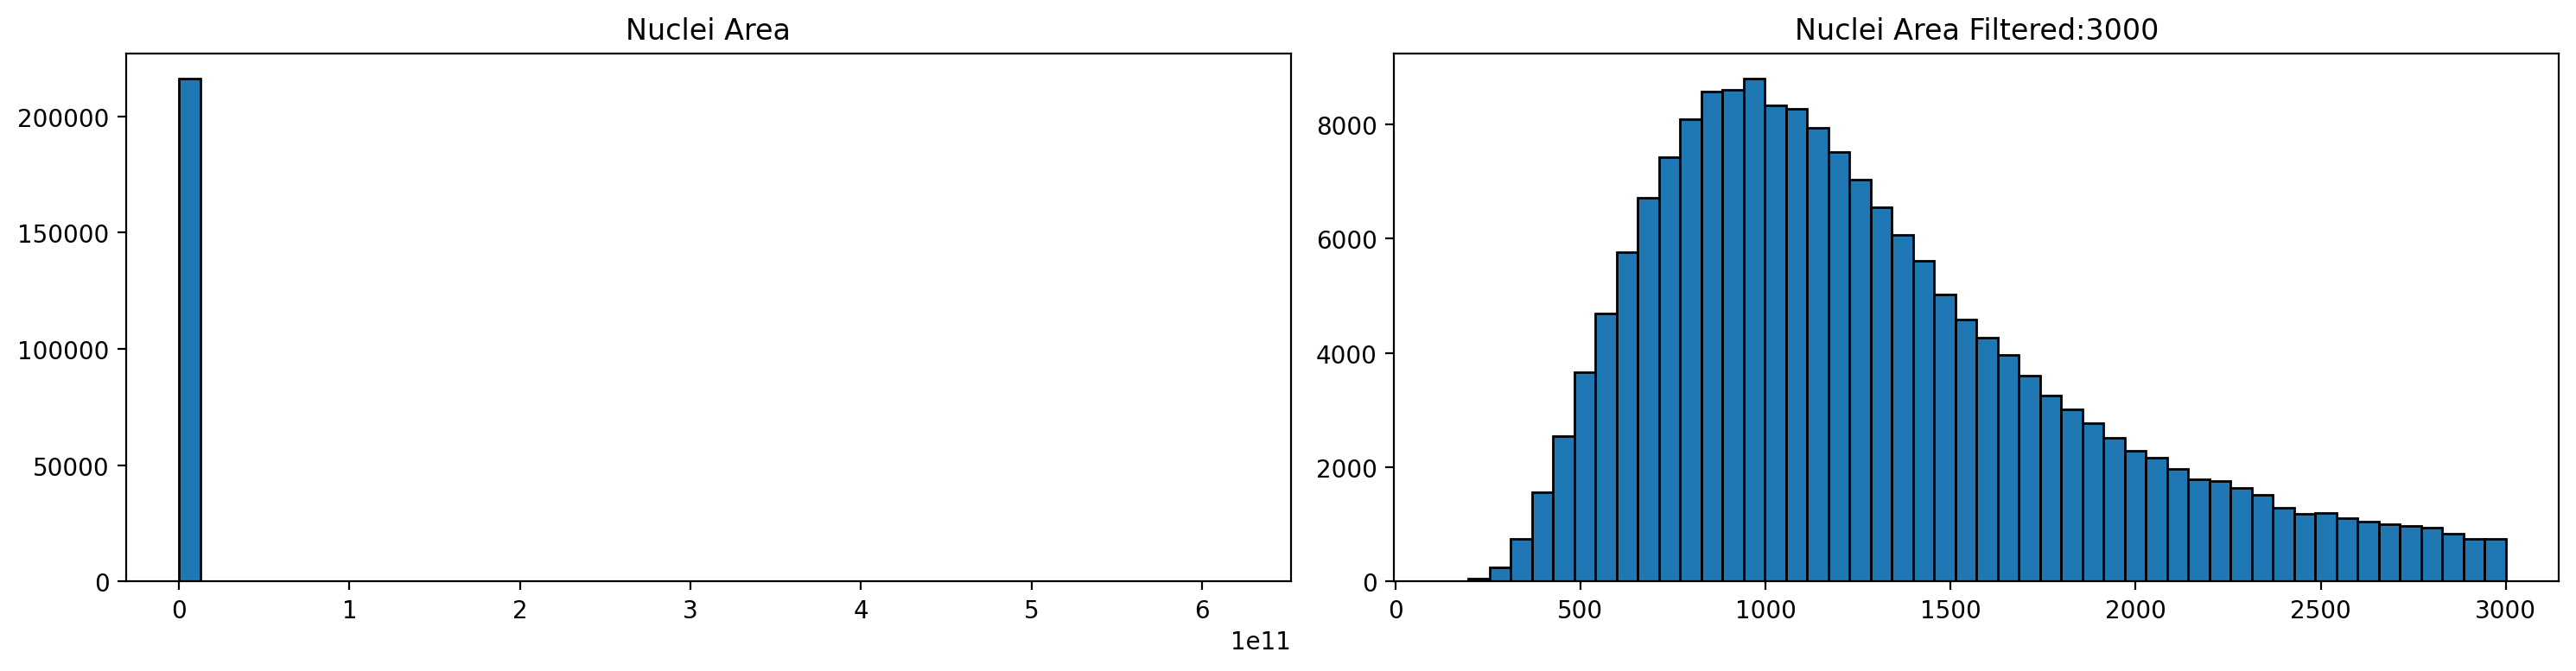

In [42]:
import sys
sys.path.append('../src/utils')
import os

import importlib
import image_plot_utils

# Reload the module
importlib.reload(image_plot_utils)

# Now try importing the function again
from image_plot_utils import plot_nuclei_area

# Store the area of each nucleus in the GeoDataframe
gdf['area'] = gdf['geometry'].area

# Calculate quality control metrics for the original AnnData object
sc.pp.calculate_qc_metrics(grouped_filtered_adata, inplace=True)

# Plot the nuclei area distribution before and after filtering
plot_nuclei_area(gdf=gdf,area_cut_off=3000)

In [43]:
# Create a mask based on the 'id' column for values present in 'gdf' with 'area' less than 500
mask_area = grouped_filtered_adata.obs['id'].isin(gdf[(gdf['area'] < 3000)].id)

# Create a mask based on the 'total_counts' column for values greater than 100
#ask_count = grouped_filtered_adata.obs['total_counts'] > 100

# Apply both masks to the original AnnData to create a new filtered AnnData object
count_area_filtered_adata = grouped_filtered_adata[mask_area, :]

# Calculate quality control metrics for the filtered AnnData object
sc.pp.calculate_qc_metrics(count_area_filtered_adata, inplace=True)


_qc.py (141): Trying to modify attribute `.obs` of view, initializing view as actual.


In [44]:
 # Normalize total counts for each cell in the AnnData object
sc.pp.normalize_total(count_area_filtered_adata, inplace=True)

# Logarithmize the values in the AnnData object after normalization
sc.pp.log1p(count_area_filtered_adata)

# Identify highly variable genes in the dataset using the Seurat method
sc.pp.highly_variable_genes(count_area_filtered_adata, flavor="seurat", n_top_genes=2000)

# Perform Principal Component Analysis (PCA) on the AnnData object
sc.pp.pca(count_area_filtered_adata)

# Build a neighborhood graph based on PCA components
sc.pp.neighbors(count_area_filtered_adata)

# Perform Leiden clustering on the neighborhood graph and store the results in 'clusters' column

# Adjust the resolution parameter as needed for different samples
#sc.tl.leiden(count_area_filtered_adata, resolution=0.4, key_added="clusters")


_index.py (146): Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
4284375964.py (19): In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


In [46]:
import imageio

# Load the image
img = imageio.imread('../data/xenium/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif')

268951726.py (4): Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


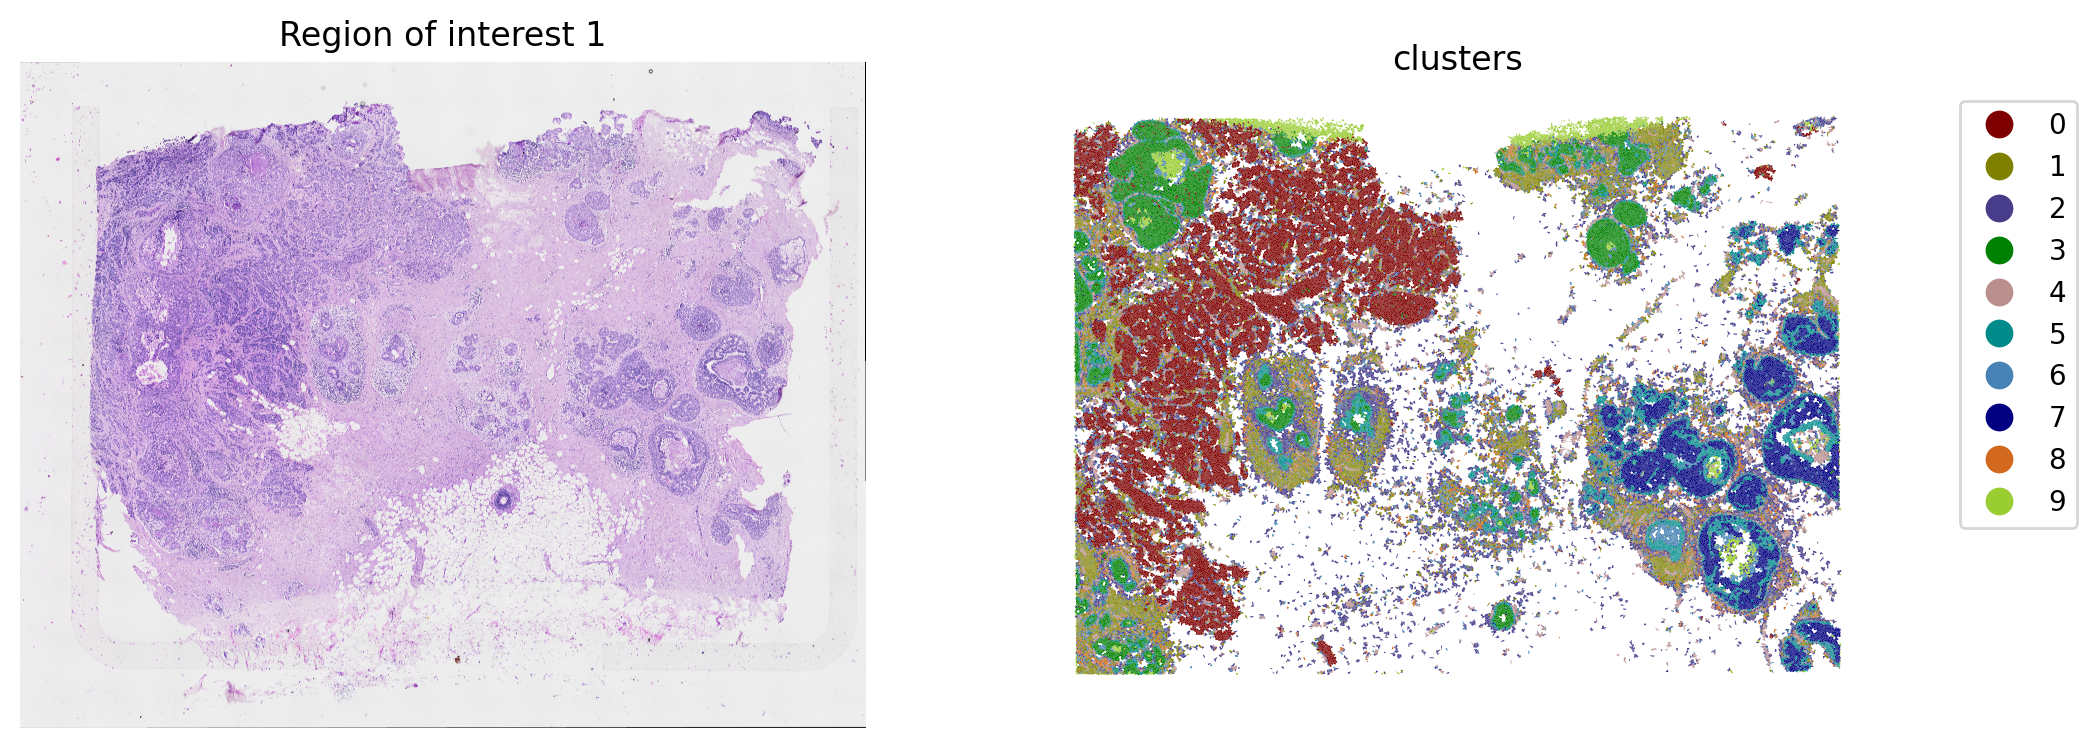

In [47]:
from image_plot_utils import plot_clusters_and_save_image
importlib.reload(image_plot_utils)
# Plot and save the clustering results
plot_clusters_and_save_image(title="Region of interest 1", gdf=gdf, img=img, adata=count_area_filtered_adata, color_by_obs='clusters', output_name="image_clustering.ROI1.tiff")

In [49]:
merged_gdf = gdf.merge(count_area_filtered_adata.obs['clusters'].astype('category'), left_on='id', right_index=True)

<Axes: >

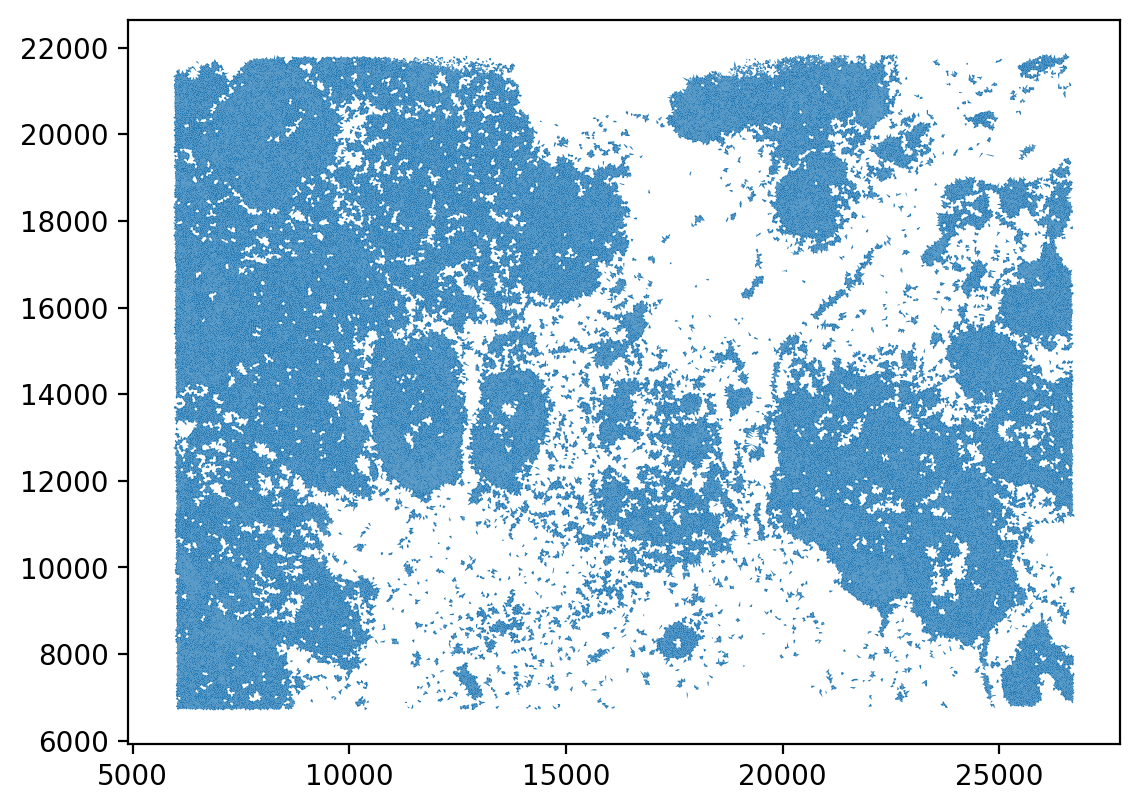

In [50]:
merged_gdf.plot()

In [58]:
merged_gdf_no_clusters = merged_gdf.drop(columns=['clusters'])

In [59]:
merged_gdf_no_clusters.to_file("../data/xenium/outs/clusters/data_cells_voronoi_merged_cosine.geojson", driver='GeoJSON')

In [53]:
count_area_filtered_adata.write("../data/xenium/outs/clusters/count_area_filtered_adata_voronoi.h5ad")

# Save cluster assignments
count_area_filtered_adata.obs[['clusters']].to_csv("../data/xenium/outs/clusters/cluster_assignments_voronoi_leiden.csv")

# Save GeoDataFrame
gdf.to_file("../data/xenium/outs/clusters/data_cells_voronoi.geojson", driver='GeoJSON')

In [60]:
merged_gdf_no_clusters

geometry         id   
6202    POLYGON ((7110.770 6825.238, 7124.374 6854.249...    ID_6203  \
6209    POLYGON ((6279.099 6982.299, 6281.607 6953.524...    ID_6210   
6212    POLYGON ((7193.251 6729.451, 7208.089 6732.524...    ID_6213   
6226    POLYGON ((6454.599 7248.218, 6443.083 7263.338...    ID_6227   
6230    POLYGON ((6907.168 7168.644, 6922.874 7168.744...    ID_6231   
...                                                   ...        ...   
215188  POLYGON ((24366.226 21234.299, 24332.589 21219...  ID_215189   
215189  POLYGON ((25935.394 21766.393, 25909.894 21765...  ID_215190   
215191  POLYGON ((26626.521 21099.852, 26611.965 21188...  ID_215192   
215192  POLYGON ((25655.911 21595.849, 25644.229 21622...  ID_215193   
215194  POLYGON ((24867.454 21126.586, 24805.642 21121...  ID_215195   

               area  
6202    1381.070529  
6209    1063.208957  
6212     532.757244  
6226     679.964088  
6230     905.575888  
...             ...  
215188  1704.299889  
215189   581.398304  
215191  2774.254191  
215192  1571.738396  
215194  2053.502814  

[132054 rows x 3 columns]

<Axes: >

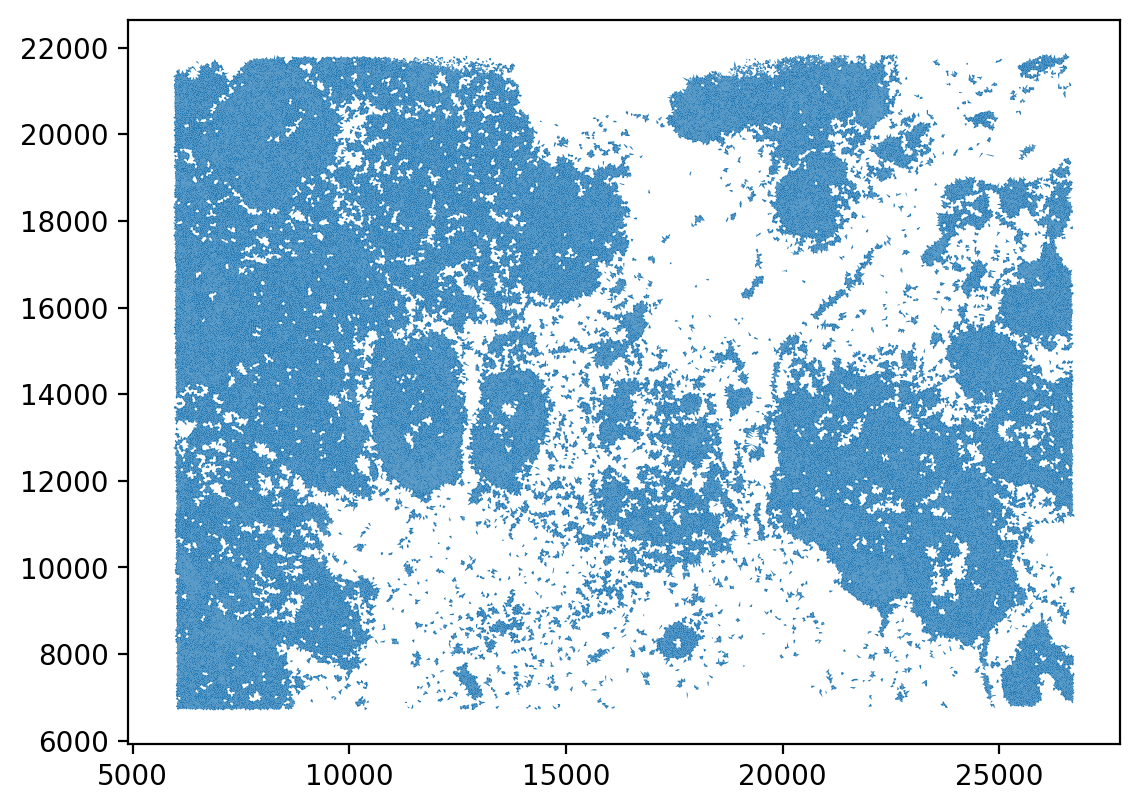

In [61]:
merged_gdf_no_clusters.plot()

In [9]:
import sys
sys.path.append('../src/utils')
import os

# Importing importlib for module reloading
import importlib
import image_cropp_utils

# Reloading the module
importlib.reload(image_cropp_utils)

from image_cropp_utils import load_dataframe

In [10]:
cells_data = load_dataframe('../data/xenium/outs/cells.parquet')

In [11]:
cells_data

cell_id   x_centroid   y_centroid  transcript_counts   
0             1   847.259912   326.191365                 28  \
1             2   826.341995   328.031830                 94   
2             3   848.766919   331.743187                  9   
3             4   824.228409   334.252643                 11   
4             5   841.357538   332.242505                 48   
...         ...          ...          ...                ...   
167775   167776  7455.475342  5114.875415                229   
167776   167777  7483.727051  5111.477490                 79   
167777   167778  7470.159424  5119.132056                397   
167778   167779  7477.737207  5128.712817                117   
167779   167780  7489.376562  5123.197778                378   

        control_probe_counts  control_codeword_counts  total_counts   
0                          1                        0            29  \
1                          0                        0            94   
2                          0                        0             9   
3                          0                        0            11   
4                          0                        0            48   
...                      ...                      ...           ...   
167775                     1                        0           230   
167776                     0                        0            79   
167777                     0                        0           397   
167778                     0                        0           117   
167779                     0                        0           378   

         cell_area  nucleus_area  
0        58.387031     26.642188  
1       197.016719     42.130781  
2        16.256250     12.688906  
3        42.311406     10.069844  
4       107.652500     37.479688  
...            ...           ...  
167775  220.452813     60.599688  
167776   37.389375     25.242344  
167777  287.058281     86.700000  
167778  235.354375     25.197188  
167779  270.079531    111.806875  

[167780 rows x 9 columns]

In [13]:
import numpy as np
transform_matrix = np.array([
    [1.7125010585876286, 0.008345081015717404, -10397.19948741904],
    [0.008345081015717404, -1.7125010585876286, 37211.538978661185],
    [0, 0, 1]
])

# Get the inverse matrix
transform_matrix_inv = np.linalg.inv(transform_matrix)

# Extract coordinates and apply scaling
coords = cells_data[['x_centroid', 'y_centroid']].values
micron_to_pixel = 0.2125  # Microns per pixel
coords_scaled = coords / micron_to_pixel

# Function to transform coordinates
def transform_coordinates(coords, transform_matrix):
    coords = np.hstack((coords, np.ones((len(coords), 1))))
    transformed_coords = np.dot(transform_matrix, coords.T).T
    # Return only the x and y coordinates
    return transformed_coords[:, :2]

# Apply the transformation to the scaled coordinates
transformed_coords = transform_coordinates(coords_scaled, transform_matrix_inv)

# Update the DataFrame with the transformed coordinates
cells_data[['x_location_transformed', 'y_location_transformed']] = transformed_coords

In [14]:
from shapely.geometry import Polygon, Point
# Create a GeoDataFrame from cells_data
geometry = [Point(xy) for xy in zip(cells_data['x_location_transformed'], cells_data['y_location_transformed'])]
cells_gdf = gpd.GeoDataFrame(cells_data, geometry=geometry)
cells_gdf.crs = None

In [15]:
cells_gdf

cell_id   x_centroid   y_centroid  transcript_counts   
0             1   847.259912   326.191365                 28  \
1             2   826.341995   328.031830                 94   
2             3   848.766919   331.743187                  9   
3             4   824.228409   334.252643                 11   
4             5   841.357538   332.242505                 48   
...         ...          ...          ...                ...   
167775   167776  7455.475342  5114.875415                229   
167776   167777  7483.727051  5111.477490                 79   
167777   167778  7470.159424  5119.132056                397   
167778   167779  7477.737207  5128.712817                117   
167779   167780  7489.376562  5123.197778                378   

        control_probe_counts  control_codeword_counts  total_counts   
0                          1                        0            29  \
1                          0                        0            94   
2                          0                        0             9   
3                          0                        0            11   
4                          0                        0            48   
...                      ...                      ...           ...   
167775                     1                        0           230   
167776                     0                        0            79   
167777                     0                        0           397   
167778                     0                        0           117   
167779                     0                        0           378   

         cell_area  nucleus_area  x_location_transformed   
0        58.387031     26.642188             8297.871957  \
1       197.016719     42.130781             8240.416393   
2        16.256250     12.688906             8302.087393   
3        42.311406     10.069844             8234.691783   
4       107.652500     37.479688             8281.733889   
...            ...           ...                     ...   
167775  220.452813     60.599688            26520.667780   
167776   37.389375     25.242344            26598.254969   
167777  287.058281     86.700000            26561.075074   
167778  235.354375     25.197188            26582.026307   
167779  270.079531    111.806875            26613.936167   

        y_location_transformed                    geometry  
0                 20873.427800  POINT (8297.872 20873.428)  
1                 20868.090296  POINT (8240.416 20868.090)  
2                 20858.192164  POINT (8302.087 20858.192)  
3                 20850.967862  POINT (8234.692 20850.968)  
4                 20856.720876  POINT (8281.734 20856.721)  
...                        ...                         ...  
167775             7803.121686  POINT (26520.668 7803.122)  
167776             7812.837128  POINT (26598.255 7812.837)  
167777             7791.621519  POINT (26561.075 7791.622)  
167778             7765.396076  POINT (26582.026 7765.396)  
167779             7780.706674  POINT (26613.936 7780.707)  

[167780 rows x 12 columns]

<Axes: >

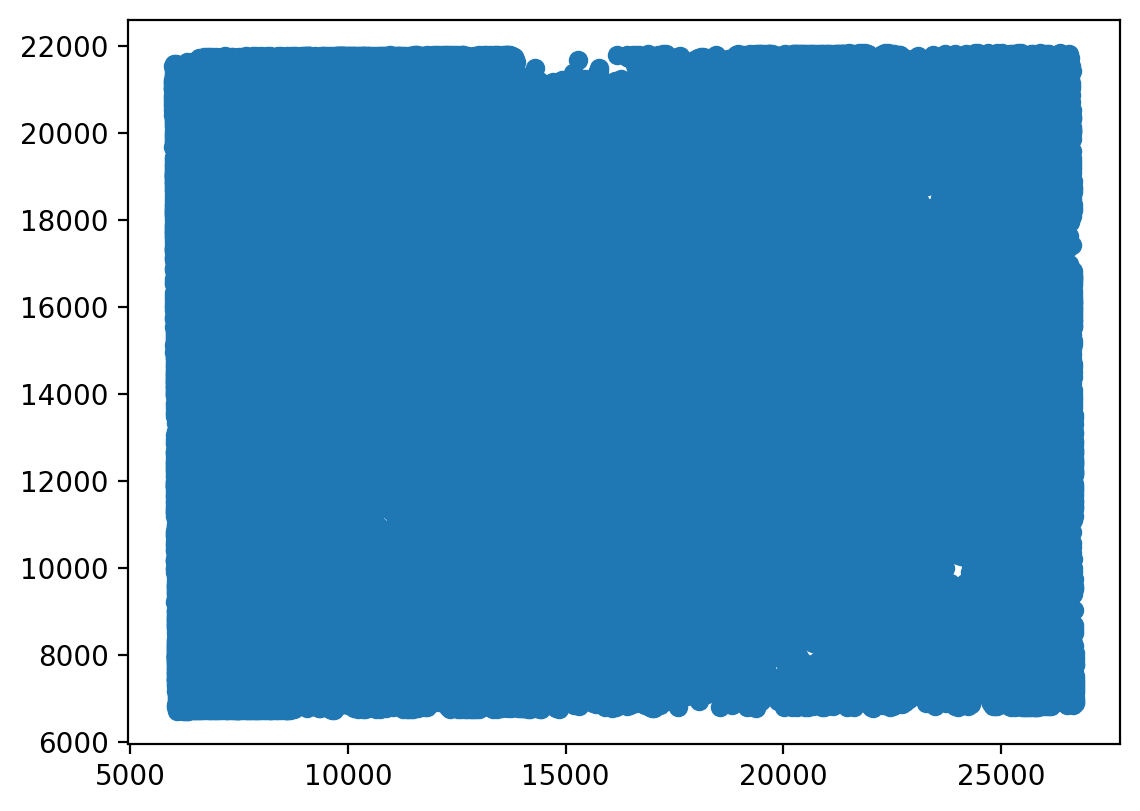

In [67]:
cells_gdf.plot()

In [71]:
merged_gdf_no_clusters

geometry         id   
6202    POLYGON ((7110.770 6825.238, 7124.374 6854.249...    ID_6203  \
6209    POLYGON ((6279.099 6982.299, 6281.607 6953.524...    ID_6210   
6212    POLYGON ((7193.251 6729.451, 7208.089 6732.524...    ID_6213   
6226    POLYGON ((6454.599 7248.218, 6443.083 7263.338...    ID_6227   
6230    POLYGON ((6907.168 7168.644, 6922.874 7168.744...    ID_6231   
...                                                   ...        ...   
215188  POLYGON ((24366.226 21234.299, 24332.589 21219...  ID_215189   
215189  POLYGON ((25935.394 21766.393, 25909.894 21765...  ID_215190   
215191  POLYGON ((26626.521 21099.852, 26611.965 21188...  ID_215192   
215192  POLYGON ((25655.911 21595.849, 25644.229 21622...  ID_215193   
215194  POLYGON ((24867.454 21126.586, 24805.642 21121...  ID_215195   

               area  
6202    1381.070529  
6209    1063.208957  
6212     532.757244  
6226     679.964088  
6230     905.575888  
...             ...  
215188  1704.299889  
215189   581.398304  
215191  2774.254191  
215192  1571.738396  
215194  2053.502814  

[132054 rows x 3 columns]

In [72]:
cells_gdf

cell_id   x_centroid   y_centroid  transcript_counts   
0             1   847.259912   326.191365                 28  \
1             2   826.341995   328.031830                 94   
2             3   848.766919   331.743187                  9   
3             4   824.228409   334.252643                 11   
4             5   841.357538   332.242505                 48   
...         ...          ...          ...                ...   
167775   167776  7455.475342  5114.875415                229   
167776   167777  7483.727051  5111.477490                 79   
167777   167778  7470.159424  5119.132056                397   
167778   167779  7477.737207  5128.712817                117   
167779   167780  7489.376562  5123.197778                378   

        control_probe_counts  control_codeword_counts  total_counts   
0                          1                        0            29  \
1                          0                        0            94   
2                          0                        0             9   
3                          0                        0            11   
4                          0                        0            48   
...                      ...                      ...           ...   
167775                     1                        0           230   
167776                     0                        0            79   
167777                     0                        0           397   
167778                     0                        0           117   
167779                     0                        0           378   

         cell_area  nucleus_area  x_location_transformed   
0        58.387031     26.642188             8297.871957  \
1       197.016719     42.130781             8240.416393   
2        16.256250     12.688906             8302.087393   
3        42.311406     10.069844             8234.691783   
4       107.652500     37.479688             8281.733889   
...            ...           ...                     ...   
167775  220.452813     60.599688            26520.667780   
167776   37.389375     25.242344            26598.254969   
167777  287.058281     86.700000            26561.075074   
167778  235.354375     25.197188            26582.026307   
167779  270.079531    111.806875            26613.936167   

        y_location_transformed                    geometry  
0                 20873.427800  POINT (8297.872 20873.428)  
1                 20868.090296  POINT (8240.416 20868.090)  
2                 20858.192164  POINT (8302.087 20858.192)  
3                 20850.967862  POINT (8234.692 20850.968)  
4                 20856.720876  POINT (8281.734 20856.721)  
...                        ...                         ...  
167775             7803.121686  POINT (26520.668 7803.122)  
167776             7812.837128  POINT (26598.255 7812.837)  
167777             7791.621519  POINT (26561.075 7791.622)  
167778             7765.396076  POINT (26582.026 7765.396)  
167779             7780.706674  POINT (26613.936 7780.707)  

[167780 rows x 12 columns]

In [78]:
# Perform spatial join
joined = gpd.sjoin(merged_gdf_no_clusters, cells_gdf, how='left', predicate='intersects')

In [35]:
joined = gpd.sjoin(cells_gdf, gdf, how='left', predicate='within')

/var/folders/fd/jw2fvp1178s0spb_1sy9f51h0000gn/T/ipykernel_21686/3875439148.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  joined = gpd.sjoin(cells_gdf, gdf, how='left', predicate='within')


In [36]:
joined

cell_id   x_centroid   y_centroid  transcript_counts   
0             1   847.259912   326.191365                 28  \
1             2   826.341995   328.031830                 94   
2             3   848.766919   331.743187                  9   
3             4   824.228409   334.252643                 11   
4             5   841.357538   332.242505                 48   
...         ...          ...          ...                ...   
167775   167776  7455.475342  5114.875415                229   
167776   167777  7483.727051  5111.477490                 79   
167777   167778  7470.159424  5119.132056                397   
167778   167779  7477.737207  5128.712817                117   
167779   167780  7489.376562  5123.197778                378   

        control_probe_counts  control_codeword_counts  total_counts   
0                          1                        0            29  \
1                          0                        0            94   
2                          0                        0             9   
3                          0                        0            11   
4                          0                        0            48   
...                      ...                      ...           ...   
167775                     1                        0           230   
167776                     0                        0            79   
167777                     0                        0           397   
167778                     0                        0           117   
167779                     0                        0           378   

         cell_area  nucleus_area  x_location_transformed   
0        58.387031     26.642188             8297.871957  \
1       197.016719     42.130781             8240.416393   
2        16.256250     12.688906             8302.087393   
3        42.311406     10.069844             8234.691783   
4       107.652500     37.479688             8281.733889   
...            ...           ...                     ...   
167775  220.452813     60.599688            26520.667780   
167776   37.389375     25.242344            26598.254969   
167777  287.058281     86.700000            26561.075074   
167778  235.354375     25.197188            26582.026307   
167779  270.079531    111.806875            26613.936167   

        y_location_transformed                    geometry  index_right   
0                 20873.427800  POINT (8297.872 20873.428)       203612  \
1                 20868.090296  POINT (8240.416 20868.090)       203480   
2                 20858.192164  POINT (8302.087 20858.192)       203612   
3                 20850.967862  POINT (8234.692 20850.968)       203480   
4                 20856.720876  POINT (8281.734 20856.721)       203612   
...                        ...                         ...          ...   
167775             7803.121686  POINT (26520.668 7803.122)        55792   
167776             7812.837128  POINT (26598.255 7812.837)        52524   
167777             7791.621519  POINT (26561.075 7791.622)        52273   
167778             7765.396076  POINT (26582.026 7765.396)        55084   
167779             7780.706674  POINT (26613.936 7780.707)        52524   

               id  
0       ID_203613  
1       ID_203481  
2       ID_203613  
3       ID_203481  
4       ID_203613  
...           ...  
167775   ID_55793  
167776   ID_52525  
167777   ID_52274  
167778   ID_55085  
167779   ID_52525  

[167780 rows x 14 columns]

In [27]:
filtered_joined.to_file("../data/xenium/improved_outs/joined.geojson", driver='GeoJSON')

In [38]:
import geopandas as gpd
filtered_joined = gpd.read_file('../data/xenium/improved_outs/joined.geojson')

In [7]:
filtered_joined[filtered_joined['cell_id']==133665.0]

id  index_right   cell_id   x_centroid   y_centroid   
68304  ID_100036     133664.0  133665.0  5327.231396  3768.727344  \

       transcript_counts  control_probe_counts  control_codeword_counts   
68304               31.0                   0.0                      0.0  \

       total_counts  cell_area  nucleus_area  x_location_transformed   
68304          31.0  40.279375     18.649531            20654.454265  \

       y_location_transformed   
68304            11473.694848  \

                                                geometry  
68304  POLYGON ((20645.46313 11484.90644, 20658.47221...

In [37]:
filtered_joined = joined[~joined['index_right'].isna()]

In [39]:
filtered_joined

id  index_right   cell_id   x_centroid   y_centroid   
0         ID_6203      42284.0   42285.0   399.355255  5437.458716  \
1         ID_6210      42966.0   42967.0    82.964026  5382.626245   
2         ID_6227      43061.0   43062.0   145.100730  5281.886304   
3         ID_6231      42582.0   42583.0   318.665202  5303.403174   
4         ID_6243      43041.0   43042.0    64.706159  5305.564697   
...           ...          ...       ...          ...          ...   
167775  ID_215151     150706.0  150707.0  6780.770825   316.917836   
167776  ID_215162      12176.0   12177.0  6817.952515     8.849210   
167777  ID_215171      12242.0   12243.0  7417.128223    26.647450   
167778  ID_215171      12241.0   12242.0  7423.180322     9.744251   
167779  ID_215193     151019.0  151020.0  7148.162988    85.906860   

        transcript_counts  control_probe_counts  control_codeword_counts   
0                   592.0                   0.0                      0.0  \
1                   173.0                   0.0                      0.0   
2                   108.0                   0.0                      0.0   
3                   252.0                   1.0                      0.0   
4                    97.0                   0.0                      0.0   
...                   ...                   ...                      ...   
167775              346.0                   0.0                      0.0   
167776               17.0                   0.0                      0.0   
167777              269.0                   0.0                      0.0   
167778               68.0                   0.0                      0.0   
167779               88.0                   0.0                      0.0   

        total_counts   cell_area  nucleus_area  x_location_transformed   
0              592.0  398.142656    147.525469             7135.520510  \
1              173.0  179.405781     55.813125             6265.376854   
2              108.0  110.632812     36.079844             6434.772936   
3              253.0  150.280000     75.320625             6911.997752   
4               97.0  108.962031     28.854844             6214.174281   
...              ...         ...           ...                     ...   
167775         346.0  500.376406     28.674219            24602.404125   
167776          17.0  520.425781     13.953281            24700.450230   
167777         269.0  409.522031      8.037812            26347.159620   
167778          68.0  633.813125      9.844062            26363.563802   
167779          88.0   77.126875     17.881875            25608.865307   

        y_location_transformed   
0                  6822.211526  \
1                  6968.648654   
2                  7246.303336   
3                  7189.501397   
4                  7180.161100   
...                        ...   
167775            20978.363664   
167776            21825.401338   
167777            21784.516984   
167778            21831.046215   
167779            21618.076830   

                                                 geometry  
0       POLYGON ((7110.76958 6825.23779, 7124.37383 68...  
1       POLYGON ((6279.09922 6982.29949, 6281.60677 69...  
2       POLYGON ((6454.59923 7248.21802, 6443.08310 72...  
3       POLYGON ((6907.16755 7168.64380, 6922.87443 71...  
4       POLYGON ((6197.15225 7191.23388, 6198.14466 71...  
...                                                   ...  
167775  POLYGON ((24644.67201 21027.91754, 24632.96144...  
167776  POLYGON ((24721.27345 21834.45736, 24626.16810...  
167777  POLYGON ((26325.46164 21748.07328, 26364.10917...  
167778  POLYGON ((26325.46164 21748.07328, 26364.10917...  
167779  POLYGON ((25655.91110 21595.84870, 25644.22933...  

[167780 rows x 14 columns]

In [28]:
unique_ids = filtered_joined['id'].unique()

In [31]:
len(unique_ids)

134784

In [87]:
filtered_adata.obs

sample       start_x       start_y         end_x         end_y   
bin                                                                            
(0, 1376)    sample1   5977.914968  19691.259132   5987.326733  19700.670896  \
(0, 1400)    sample1   5977.914968  19917.141485   5987.326733  19926.553249   
(0, 1402)    sample1   5977.914968  19935.965014   5987.326733  19945.376779   
(0, 1415)    sample1   5977.914968  20058.317955   5987.326733  20067.729720   
(0, 1425)    sample1   5977.914968  20152.435602   5987.326733  20161.847367   
...              ...           ...           ...           ...           ...   
(2201, 146)  sample1  26693.209086   8114.788543  26702.620851   8124.200308   
(2201, 147)  sample1  26693.209086   8124.200308  26702.620851   8133.612073   
(2201, 148)  sample1  26693.209086   8133.612073  26702.620851   8143.023838   
(2201, 153)  sample1  26693.209086   8180.670896  26702.620851   8190.082661   
(2201, 154)  sample1  26693.209086   8190.082661  26702.620851   8199.494426   

                 center_x      center_y  n_genes_by_counts   
bin                                                          
(0, 1376)     5982.620851  19695.965014                  1  \
(0, 1400)     5982.620851  19921.847367                  1   
(0, 1402)     5982.620851  19940.670896                  2   
(0, 1415)     5982.620851  20063.023838                  1   
(0, 1425)     5982.620851  20157.141485                  1   
...                   ...           ...                ...   
(2201, 146)  26697.914968   8119.494426                  2   
(2201, 147)  26697.914968   8128.906190                  1   
(2201, 148)  26697.914968   8138.317955                  1   
(2201, 153)  26697.914968   8185.376779                  1   
(2201, 154)  26697.914968   8194.788543                  1   

             log1p_n_genes_by_counts  total_counts  log1p_total_counts   
bin                                                                      
(0, 1376)                   0.693147             1            0.693147  \
(0, 1400)                   0.693147             1            0.693147   
(0, 1402)                   1.098612             2            1.098612   
(0, 1415)                   0.693147             1            0.693147   
(0, 1425)                   0.693147             1            0.693147   
...                              ...           ...                 ...   
(2201, 146)                 1.098612             2            1.098612   
(2201, 147)                 0.693147             1            0.693147   
(2201, 148)                 0.693147             1            0.693147   
(2201, 153)                 0.693147             1            0.693147   
(2201, 154)                 0.693147             1            0.693147   

             pct_counts_in_top_50_genes  pct_counts_in_top_100_genes   
bin                                                                    
(0, 1376)                         100.0                        100.0  \
(0, 1400)                         100.0                        100.0   
(0, 1402)                         100.0                        100.0   
(0, 1415)                         100.0                        100.0   
(0, 1425)                         100.0                        100.0   
...                                 ...                          ...   
(2201, 146)                       100.0                        100.0   
(2201, 147)                       100.0                        100.0   
(2201, 148)                       100.0                        100.0   
(2201, 153)                       100.0                        100.0   
(2201, 154)                       100.0                        100.0   

             pct_counts_in_top_200_genes  pct_counts_in_top_500_genes   
bin                                                                     
(0, 1376)                          100.0                        100.0  \
(0, 1400)                          100.0       

In [32]:

indices_to_keep = filtered_adata.obs['id'].isin(unique_ids)

# Filter the entire AnnData object
filtered_adata2 = filtered_adata[indices_to_keep].copy()

NameError: name 'filtered_adata' is not defined

In [116]:
filtered_adata2.obs

sample       start_x       start_y         end_x         end_y   
bin                                                                            
(0, 1376)    sample1   5977.914968  19691.259132   5987.326733  19700.670896  \
(0, 1400)    sample1   5977.914968  19917.141485   5987.326733  19926.553249   
(0, 1402)    sample1   5977.914968  19935.965014   5987.326733  19945.376779   
(0, 1431)    sample1   5977.914968  20208.906190   5987.326733  20218.317955   
(0, 1434)    sample1   5977.914968  20237.141485   5987.326733  20246.553249   
...              ...           ...           ...           ...           ...   
(2201, 122)  sample1  26693.209086   7888.906190  26702.620851   7898.317955   
(2201, 123)  sample1  26693.209086   7898.317955  26702.620851   7907.729720   
(2201, 124)  sample1  26693.209086   7907.729720  26702.620851   7917.141485   
(2201, 126)  sample1  26693.209086   7926.553249  26702.620851   7935.965014   
(2201, 128)  sample1  26693.209086   7945.376779  26702.620851   7954.788543   

                 center_x      center_y  n_genes_by_counts   
bin                                                          
(0, 1376)     5982.620851  19695.965014                  1  \
(0, 1400)     5982.620851  19921.847367                  1   
(0, 1402)     5982.620851  19940.670896                  2   
(0, 1431)     5982.620851  20213.612073                  1   
(0, 1434)     5982.620851  20241.847367                  1   
...                   ...           ...                ...   
(2201, 122)  26697.914968   7893.612073                  1   
(2201, 123)  26697.914968   7903.023838                  1   
(2201, 124)  26697.914968   7912.435602                  1   
(2201, 126)  26697.914968   7931.259132                  1   
(2201, 128)  26697.914968   7950.082661                  1   

             log1p_n_genes_by_counts  total_counts  log1p_total_counts   
bin                                                                      
(0, 1376)                   0.693147             1            0.693147  \
(0, 1400)                   0.693147             1            0.693147   
(0, 1402)                   1.098612             2            1.098612   
(0, 1431)                   0.693147             1            0.693147   
(0, 1434)                   0.693147             1            0.693147   
...                              ...           ...                 ...   
(2201, 122)                 0.693147             1            0.693147   
(2201, 123)                 0.693147             1            0.693147   
(2201, 124)                 0.693147             1            0.693147   
(2201, 126)                 0.693147             1            0.693147   
(2201, 128)                 0.693147             1            0.693147   

             pct_counts_in_top_50_genes  pct_counts_in_top_100_genes   
bin                                                                    
(0, 1376)                         100.0                        100.0  \
(0, 1400)                         100.0                        100.0   
(0, 1402)                         100.0                        100.0   
(0, 1431)                         100.0                        100.0   
(0, 1434)                         100.0                        100.0   
...                                 ...                          ...   
(2201, 122)                       100.0                        100.0   
(2201, 123)                       100.0                        100.0   
(2201, 124)                       100.0                        100.0   
(2201, 126)                       100.0                        100.0   
(2201, 128)                       100.0                        100.0   

             pct_counts_in_top_200_genes  pct_counts_in_top_500_genes   
bin                                                                     
(0, 1376)                          100.0                        100.0  \
(0, 1400)                          100.0       

In [93]:
filtered_adata2

AnnData object with n_obs × n_vars = 1659335 × 541
    obs: 'sample', 'start_x', 'start_y', 'end_x', 'end_y', 'center_x', 'center_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'index', 'geometry', 'id', 'is_within_polygon', 'is_not_in_an_polygon_overlap'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'end_x', 'end_y', 'spatial', 'start_x', 'start_y'

In [95]:
groupby_object = filtered_adata2.obs.groupby(['id'], observed=True)

In [130]:
import numpy as np

def get_min_max_ids_numpy(id_dict):
    # Convert all arrays to a single flat array
    all_ids = np.concatenate(list(id_dict.values()))
    
    # Find the min and max
    min_id = np.min(all_ids)
    max_id = np.max(all_ids)
    
    return min_id, max_id


min_id, max_id = get_min_max_ids_numpy(groupby_object.indices)
print("Min ID:", min_id)
print("Max ID:", max_id)


Min ID: 0
Max ID: 1659334


In [123]:
filtered_adata2.obs

sample       start_x       start_y         end_x         end_y   
bin                                                                            
(0, 1376)    sample1   5977.914968  19691.259132   5987.326733  19700.670896  \
(0, 1400)    sample1   5977.914968  19917.141485   5987.326733  19926.553249   
(0, 1402)    sample1   5977.914968  19935.965014   5987.326733  19945.376779   
(0, 1431)    sample1   5977.914968  20208.906190   5987.326733  20218.317955   
(0, 1434)    sample1   5977.914968  20237.141485   5987.326733  20246.553249   
...              ...           ...           ...           ...           ...   
(2201, 122)  sample1  26693.209086   7888.906190  26702.620851   7898.317955   
(2201, 123)  sample1  26693.209086   7898.317955  26702.620851   7907.729720   
(2201, 124)  sample1  26693.209086   7907.729720  26702.620851   7917.141485   
(2201, 126)  sample1  26693.209086   7926.553249  26702.620851   7935.965014   
(2201, 128)  sample1  26693.209086   7945.376779  26702.620851   7954.788543   

                 center_x      center_y  n_genes_by_counts   
bin                                                          
(0, 1376)     5982.620851  19695.965014                  1  \
(0, 1400)     5982.620851  19921.847367                  1   
(0, 1402)     5982.620851  19940.670896                  2   
(0, 1431)     5982.620851  20213.612073                  1   
(0, 1434)     5982.620851  20241.847367                  1   
...                   ...           ...                ...   
(2201, 122)  26697.914968   7893.612073                  1   
(2201, 123)  26697.914968   7903.023838                  1   
(2201, 124)  26697.914968   7912.435602                  1   
(2201, 126)  26697.914968   7931.259132                  1   
(2201, 128)  26697.914968   7950.082661                  1   

             log1p_n_genes_by_counts  total_counts  log1p_total_counts   
bin                                                                      
(0, 1376)                   0.693147             1            0.693147  \
(0, 1400)                   0.693147             1            0.693147   
(0, 1402)                   1.098612             2            1.098612   
(0, 1431)                   0.693147             1            0.693147   
(0, 1434)                   0.693147             1            0.693147   
...                              ...           ...                 ...   
(2201, 122)                 0.693147             1            0.693147   
(2201, 123)                 0.693147             1            0.693147   
(2201, 124)                 0.693147             1            0.693147   
(2201, 126)                 0.693147             1            0.693147   
(2201, 128)                 0.693147             1            0.693147   

             pct_counts_in_top_50_genes  pct_counts_in_top_100_genes   
bin                                                                    
(0, 1376)                         100.0                        100.0  \
(0, 1400)                         100.0                        100.0   
(0, 1402)                         100.0                        100.0   
(0, 1431)                         100.0                        100.0   
(0, 1434)                         100.0                        100.0   
...                                 ...                          ...   
(2201, 122)                       100.0                        100.0   
(2201, 123)                       100.0                        100.0   
(2201, 124)                       100.0                        100.0   
(2201, 126)                       100.0                        100.0   
(2201, 128)                       100.0                        100.0   

             pct_counts_in_top_200_genes  pct_counts_in_top_500_genes   
bin                                                                     
(0, 1376)                          100.0                        100.0  \
(0, 1400)                          100.0       

In [96]:
# Extract the gene expression counts from the AnnData object
counts = filtered_adata2.X

# Obtain the number of unique nuclei and the number of genes in the expression data
N_groups = groupby_object.ngroups
N_genes = counts.shape[1]

# Initialize a sparse matrix to store the summed gene counts for each nucleus
summed_counts = sparse.lil_matrix((N_groups, N_genes))

# Lists to store the IDs of polygons and the current row index
polygon_id = []
row = 0

# Iterate over each unique polygon to calculate the sum of gene counts.
for polygons, idx_ in groupby_object.indices.items():
    summed_counts[row] = counts[idx_].sum(0)
    row += 1
    polygon_id.append(polygons)

# Create and AnnData object from the summed count matrix
summed_counts = summed_counts.tocsr()
grouped_filtered_adata2 = anndata.AnnData(X=summed_counts,obs=pd.DataFrame(polygon_id,columns=['id'],index=polygon_id),var=filtered_adata2.var)

%store grouped_filtered_adata2


Stored 'grouped_filtered_adata2' (AnnData)


In [131]:
grouped_filtered_adata2

id  n_genes_by_counts  log1p_n_genes_by_counts   
ID_100000  ID_100000                 94                 4.553877  \
ID_100001  ID_100001                 79                 4.382027   
ID_100002  ID_100002                 46                 3.850148   
ID_100004  ID_100004                 80                 4.394449   
ID_100006  ID_100006                 55                 4.025352   
...              ...                ...                      ...   
ID_99993    ID_99993                 87                 4.477337   
ID_99996    ID_99996                 82                 4.418841   
ID_99997    ID_99997                 62                 4.143135   
ID_99998    ID_99998                 75                 4.330733   
ID_99999    ID_99999                 74                 4.317488   

           total_counts  log1p_total_counts  pct_counts_in_top_50_genes   
ID_100000         218.0            5.389072                   79.816514  \
ID_100001         394.0            5.978886                   92.639594   
ID_100002          87.0            4.477337                  100.000000   
ID_100004         305.0            5.723585                   88.524590   
ID_100006         117.0            4.770685                   95.726496   
...                 ...                 ...                         ...   
ID_99993          461.0            6.135565                   91.323210   
ID_99996          279.0            5.634790                   88.530466   
ID_99997          117.0            4.770685                   89.743590   
ID_99998          254.0            5.541264                   90.157480   
ID_99999          141.0            4.955827                   82.978723   

           pct_counts_in_top_100_genes  pct_counts_in_top_200_genes   
ID_100000                        100.0                        100.0  \
ID_100001                        100.0                        100.0   
ID_100002                        100.0                        100.0   
ID_100004                        100.0                        100.0   
ID_100006                        100.0                        100.0   
...                                ...                          ...   
ID_99993                         100.0                        100.0   
ID_99996                         100.0                        100.0   
ID_99997                         100.0                        100.0   
ID_99998                         100.0                        100.0   
ID_99999                         100.0                        100.0   

           pct_counts_in_top_500_genes  
ID_100000                        100.0  
ID_100001                        100.0  
ID_100002                        100.0  
ID_100004                        100.0  
ID_100006                        100.0  
...                                ...  
ID_99993                         100.0  
ID_99996                         100.0  
ID_99997                         100.0  
ID_99998                         100.0  
ID_99999                         100.0  

[118392 rows x 9 columns]

In [99]:
grouped_filtered_adata2.write("../data/xenium/grouped_filtered_voronoi_adata_second_attempt.h5ad")

geodataframe.py (1528): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


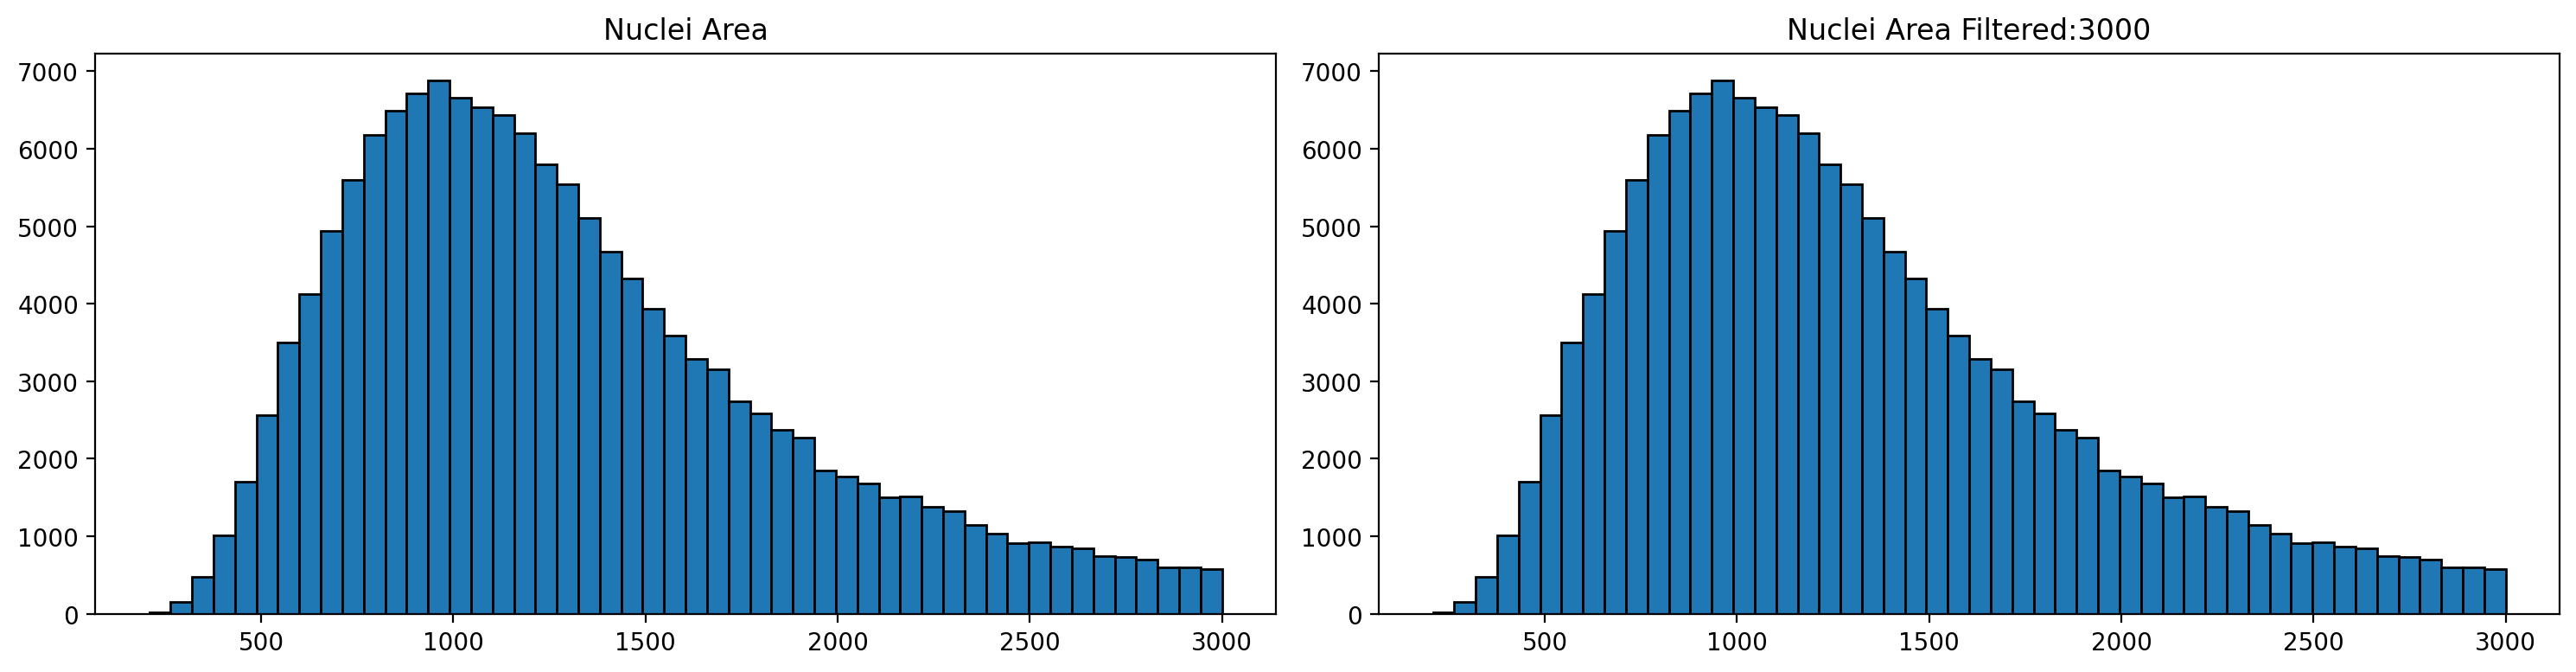

In [108]:
import sys
sys.path.append('../src/utils')
import os

import importlib
import image_plot_utils

# Reload the module
importlib.reload(image_plot_utils)

# Now try importing the function again
from image_plot_utils import plot_nuclei_area

# Store the area of each nucleus in the GeoDataframe
filtered_joined['area'] = filtered_joined['geometry'].area

# Calculate quality control metrics for the original AnnData object
sc.pp.calculate_qc_metrics(grouped_filtered_adata2, inplace=True)

# Plot the nuclei area distribution before and after filtering
plot_nuclei_area(gdf=filtered_joined,area_cut_off=3000)

In [109]:
# Create a mask based on the 'id' column for values present in 'gdf' with 'area' less than 500
mask_area = grouped_filtered_adata2.obs['id'].isin(gdf[(gdf['area'] < 3000)].id)

# Create a mask based on the 'total_counts' column for values greater than 100
#ask_count = grouped_filtered_adata.obs['total_counts'] > 100

# Apply both masks to the original AnnData to create a new filtered AnnData object
count_area_filtered_adata2 = grouped_filtered_adata2[mask_area, :]

# Calculate quality control metrics for the filtered AnnData object
sc.pp.calculate_qc_metrics(count_area_filtered_adata2, inplace=True)


_qc.py (141): Trying to modify attribute `.obs` of view, initializing view as actual.


In [110]:
 # Normalize total counts for each cell in the AnnData object
sc.pp.normalize_total(count_area_filtered_adata2, inplace=True)

# Logarithmize the values in the AnnData object after normalization
sc.pp.log1p(count_area_filtered_adata2)

# Identify highly variable genes in the dataset using the Seurat method
sc.pp.highly_variable_genes(count_area_filtered_adata2, flavor="seurat", n_top_genes=2000)

# Perform Principal Component Analysis (PCA) on the AnnData object
sc.pp.pca(count_area_filtered_adata2)

# Build a neighborhood graph based on PCA components
sc.pp.neighbors(count_area_filtered_adata2)

# Perform Leiden clustering on the neighborhood graph and store the results in 'clusters' column

# Adjust the resolution parameter as needed for different samples
sc.tl.leiden(count_area_filtered_adata2, resolution=0.4, key_added="clusters")


_index.py (146): Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


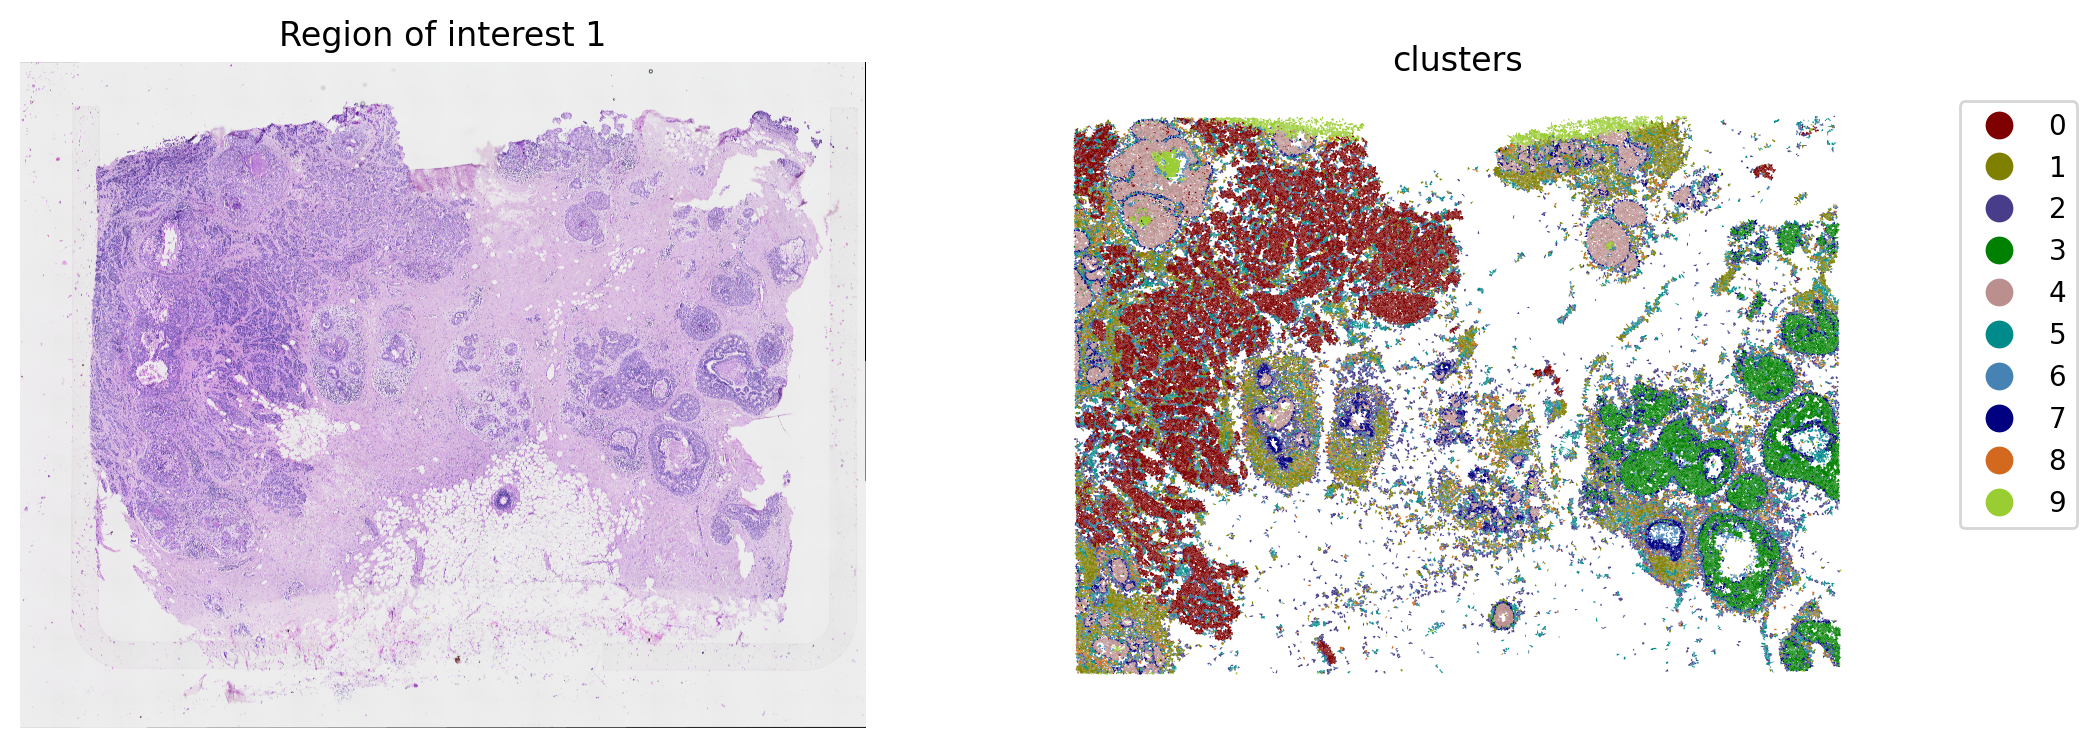

In [111]:
from image_plot_utils import plot_clusters_and_save_image
importlib.reload(image_plot_utils)
# Plot and save the clustering results
plot_clusters_and_save_image(title="Region of interest 1", gdf=filtered_joined, img=img, adata=count_area_filtered_adata2, color_by_obs='clusters', output_name="image_clustering.ROI1.tiff")

In [112]:
filtered_joined.to_file("../data/xenium/outs/clusters/data_cells_voronoi2.geojson", driver='GeoJSON')